In [1]:
%matplotlib inline
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None,real_dim), name = 'inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None,z_dim), name = 'inputs_z')
    return inputs_real, inputs_z

In [4]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    ''' build generator network.
    '''
    with tf.variable_scope('generator',reuse=reuse):
        h1 = tf.layers.dense(z,n_units,activation=None) 
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1,h1)
        
        logits = tf.layers.dense(h1,out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [5]:

def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    ''' build discriminator network.
    '''
    with tf.variable_scope('discriminator',reuse=reuse):
        h1 = tf.layers.dense(x,n_units, activation=None)   #tf.add(tf.matmul(w1,x),b1)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1,h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [6]:
input_size = 784    # discriminator的输入大小（28x28） 
z_size = 100        # generator 的输入特征向量的大小
g_hidden_size = 128 # generator的隐藏层的大小
d_hidden_size = 128 # discriminator的隐藏层的大小
alpha = 0.01        # leaky factor
smooth = 0.1        # Label smoothing

In [7]:
tf.reset_default_graph()

input_real, input_z = model_inputs(input_size,z_size)

# genertor network
g_model = generator(input_z, input_size, g_hidden_size)

# disriminator network
d_model_real, d_logits_real = discriminator(input_real)
d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [8]:

# 计算losses
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

In [9]:
# optimizers
learning_rate = 0.002

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss,var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss,var_list=g_vars)

In [10]:
!mkdir checkpoints

In [11]:

batch_size = 100
epochs = 100
samples = []
losses = []
# 只保存generator的变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # 处理images
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # 传入Generator的随机噪声
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # 运行optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # 获取loss，并print
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # save losses
        losses.append((train_loss_d, train_loss_g))
        
        # generator生成数据采样
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# 保存generator的采样
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3598... Generator Loss: 3.9417
Epoch 2/100... Discriminator Loss: 0.3578... Generator Loss: 4.0998
Epoch 3/100... Discriminator Loss: 0.4722... Generator Loss: 3.2058
Epoch 4/100... Discriminator Loss: 0.5272... Generator Loss: 3.6886
Epoch 5/100... Discriminator Loss: 0.6857... Generator Loss: 4.0472
Epoch 6/100... Discriminator Loss: 0.6689... Generator Loss: 4.1541
Epoch 7/100... Discriminator Loss: 0.9495... Generator Loss: 2.4006
Epoch 8/100... Discriminator Loss: 1.0232... Generator Loss: 2.5633
Epoch 9/100... Discriminator Loss: 0.7831... Generator Loss: 1.7965
Epoch 10/100... Discriminator Loss: 1.1181... Generator Loss: 2.7354
Epoch 11/100... Discriminator Loss: 0.7453... Generator Loss: 3.0023
Epoch 12/100... Discriminator Loss: 0.6788... Generator Loss: 2.9370
Epoch 13/100... Discriminator Loss: 0.7467... Generator Loss: 2.1748
Epoch 14/100... Discriminator Loss: 1.1897... Generator Loss: 1.6397
Epoch 15/100... Discriminator Loss: 0.9474.

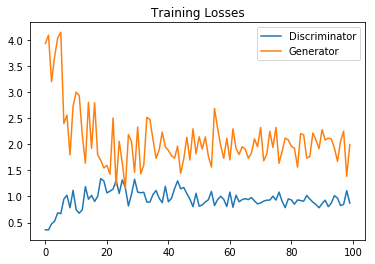

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [13]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [14]:
# 加载训练时generator的采样
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

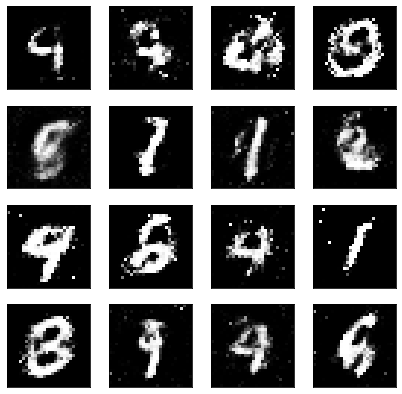

In [15]:
_ = view_samples(-1, samples)

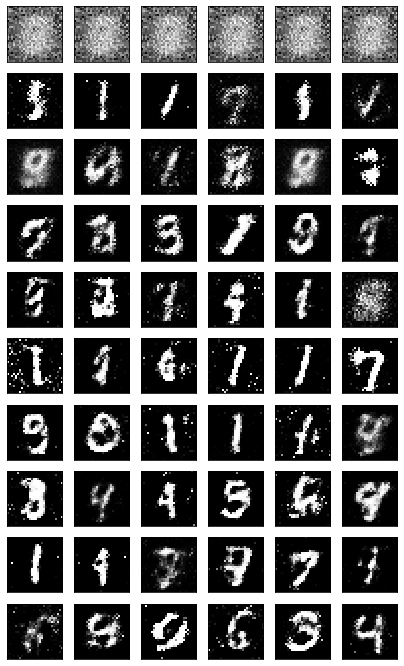

In [16]:

rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


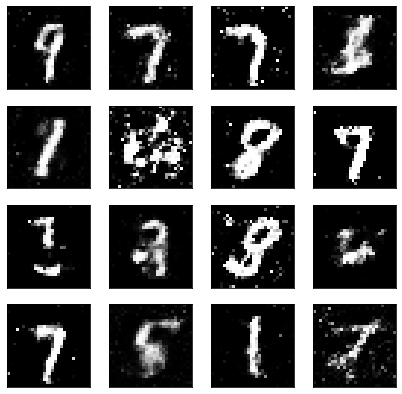

In [17]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, reuse=True),
                   feed_dict={input_z: sample_z})
_ = view_samples(0, [gen_samples])